In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from numpy.random import seed
seed(42)

import tensorflow
tensorflow.random.set_seed(42)

In [ ]:
import os
import pandas as pd
import math
import numpy as np

### Dataframes

In [ ]:
REPOSITORY_PREFIX = 'https://raw.githubusercontent.com/RonildoSilva/datasets/main/'

In [ ]:
# HelpDesk17
df_train = pd.read_csv(REPOSITORY_PREFIX+'df_train_keras_tk_hd_17_prefix.csv')
df_val = pd.read_csv(REPOSITORY_PREFIX+'df_val_keras_tk_hd_17_prefix.csv')
df_test = pd.read_csv(REPOSITORY_PREFIX+'df_test_keras_tk_hd_17_prefix.csv')

In [ ]:
df_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', 'datetime', 'Case ID', 'Duration', 'PassedTime', 'Step',
       'TimeConclusion'],
      dtype='object')

In [ ]:
df_train = df_train[df_train['TimeConclusion'] != 0]
df_val = df_val[df_val['TimeConclusion'] != 0]
df_test = df_test[df_test['TimeConclusion'] != 0]

In [ ]:
#len(df_test['Case ID'].unique())

In [ ]:
df_test_ml = pd.concat([df_val,df_test])

In [ ]:
df_test_ml['Step'].max()

9

In [ ]:
MAX_LEN_TRACE_TRAIN = df_train['Step'].max()

### Features selection

In [ ]:
FEATURES_COL = df_train.columns.tolist()
FEATURES_COL.remove('Case ID')
FEATURES_COL.remove('TimeConclusion')
FEATURES_COL.remove('datetime')

TARGET_COL = 'TimeConclusion'

In [ ]:
ACT_COLS = df_train.columns.tolist()
ACT_COLS.remove('Case ID')
ACT_COLS.remove('TimeConclusion')
ACT_COLS.remove('datetime')
ACT_COLS.remove('Duration')
ACT_COLS.remove('PassedTime')
ACT_COLS.remove('Step')

TARGET_COL = 'TimeConclusion'

In [ ]:
TIME_COLS = ['Duration', 'PassedTime', 'Step']

In [ ]:
print(ACT_COLS, sep='')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']


In [ ]:
X_train = df_train[FEATURES_COL]
X_train = X_train.values

y_train = df_train[TARGET_COL].values


X_test = df_test[FEATURES_COL]
X_test = X_test.values

y_test = df_test[TARGET_COL].values


X_val = df_val[FEATURES_COL]
X_val = X_val.values

y_val = df_val[TARGET_COL].values

In [ ]:
X_test_ml = np.concatenate((X_test, X_val), axis=0)
y_test_ml = np.concatenate((y_test, y_val), axis=0)


In [ ]:
print(X_train.shape)

(9615, 18)


In [ ]:
print(X_test_ml.shape)

(6209, 18)


### ML Experiment

In [ ]:
! pip install xgboost

In [ ]:
! pip install lightgbm

In [ ]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 11.1 MB/s eta 0:00:00


In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import lightgbm as ltb

regressors = [
        {'nome' : 'DummyRegressor', 'regressor':  DummyRegressor(strategy='mean')},
        {'nome': 'LinearRegression', 'regressor': LinearRegression(fit_intercept=False)},
        {'nome': 'RandomForestRegressor',  'regressor': RandomForestRegressor(n_estimators=20, max_features='auto',
                                                                              bootstrap=True, warm_start=True, max_depth=19, random_state=0)},
        {'nome' : 'XGBoostRegressor', 'regressor': XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)},
        {'nome' : 'LightGBM Regressor', 'regressor': ltb.LGBMRegressor(random_state=0)}
]

In [ ]:
max_len_trace = df_train['Step'].max()

In [ ]:
import time
from sklearn.metrics import mean_absolute_error

cols = [
        'Nome do modelo', 'MAE'
       ]

data_result = []

for regressor in regressors:
    t1 = time.time()
    if(regressor['nome'] == 'LightGBM Regressor'):
      regr = regressor['regressor'].fit(X_train, y_train, categorical_feature=[i for i in range(0,MAX_LEN_TRACE_TRAIN+1)])
    else:
      regr = regressor['regressor'].fit(X_train, y_train)
    tf = time.time()

    y_pred = regr.predict(X_test_ml)
    mae = mean_absolute_error(y_test_ml, y_pred)

    line = [
        regressor['nome'],
        mae
    ]
    data_result.append(line)

pd.DataFrame(data_result, columns=cols).sort_values(by='MAE', ascending=True)

,Nome do modelo,MAE
4,LightGBM Regressor,4.742676
2,RandomForestRegressor,4.844472
3,XGBoostRegressor,5.004377
0,DummyRegressor,10.114643
1,LinearRegression,10.807157


In [ ]:
MAX_STEP = df_test_ml['Step'].max()

In [ ]:
for regressor in regressors:
  step = list()
  mae = list()

  print(regressor)
  regr = regressor['regressor'].fit(X_train, y_train)
  for i in range(1, MAX_STEP+1):
    df_local_test = df_test_ml[df_test_ml['Step'] == i]
    dl_x__local_test = df_local_test[FEATURES_COL].values

    y_local_test = df_local_test[TARGET_COL]

    local_test_predicton = regr.predict(dl_x__local_test)
    mae_error = mean_absolute_error(y_local_test, local_test_predicton)

    mae.append(mae_error)
    step.append(i)

  for s, m in zip(step,mae):
    print(s,m)

{'nome': 'DummyRegressor', 'regressor': DummyRegressor()}
1 7.216941450051889
2 8.996346780553214
3 10.875211787918797
4 17.298320283942044
5 15.888354183038112
6 18.337871677867106
7 17.516315908736345
8 17.611637878315126
9 21.124804544981792
{'nome': 'LinearRegression', 'regressor': LinearRegression(fit_intercept=False)}
1 10.82123274196566
2 7.7214696950590485
3 10.80831681451211
4 12.705305174382787
5 28.201323216913703
6 30.95739919534063
7 99.22030188737318
8 210.92394203809638
9 6.961341764193799
{'nome': 'RandomForestRegressor', 'regressor': RandomForestRegressor(max_depth=19, max_features='auto', n_estimators=20,
                      random_state=0, warm_start=True)}
1 7.245256340985531
2 4.735079157714154
3 2.6204041584125863
4 3.7007925498201835
5 6.606737170004807
6 7.039886323866252
7 8.07022377264493
8 4.285920000000002
9 11.011090000000001
{'nome': 'XGBoostRegressor', 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_byleve

### Deep learning Experiment

Deep learning model definition

In [ ]:
#! pip install keras_self_attention

In [ ]:
#from keras_self_attention import SeqSelfAttention

In [ ]:
import keras

from tensorflow import keras
import tensorflow as tf

from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import PReLU
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Reshape
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Masking

from tensorflow.keras.layers import concatenate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback


from keras.layers.core import Activation
from keras.initializers import Constant

from keras.regularizers import l2

In [ ]:
dl_x_train = df_train[ACT_COLS].values
dl_x_val = df_val[ACT_COLS].values
dl_x_test = df_test[ACT_COLS].values

In [ ]:
dl_x_t_train = df_train[TIME_COLS].values
dl_x_t_val = df_val[TIME_COLS].values
dl_x_t_test = df_test[TIME_COLS].values

In [ ]:
dl_x_train = dl_x_train.reshape(dl_x_train.shape[0], dl_x_train.shape[1], 1)
dl_x_val = dl_x_val.reshape(dl_x_val.shape[0], dl_x_val.shape[1], 1)
dl_x_test = dl_x_test.reshape(dl_x_test.shape[0], dl_x_test.shape[1], 1)

In [ ]:
dl_x_t_train = dl_x_t_train.reshape(dl_x_t_train.shape[0], dl_x_t_train.shape[1], 1)
dl_x_t_val = dl_x_t_val.reshape(dl_x_t_val.shape[0], dl_x_t_val.shape[1], 1)
dl_x_t_test = dl_x_t_test.reshape(dl_x_t_test.shape[0], dl_x_t_test.shape[1], 1)

In [ ]:
n_activities = pd.concat([df_train, df_val, df_test], ignore_index=True)[ACT_COLS].to_numpy().max()

In [ ]:
n_activities

14

In [ ]:
shape = len(ACT_COLS)
shape_t = len(TIME_COLS)

- input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- output_dim: Integer. Dimension of the dense embedding.


In [ ]:
! pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=704e68b672a58b3a5ff62824e49202be5a3d6ddb92f62820b099ccd468eeea3f
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention

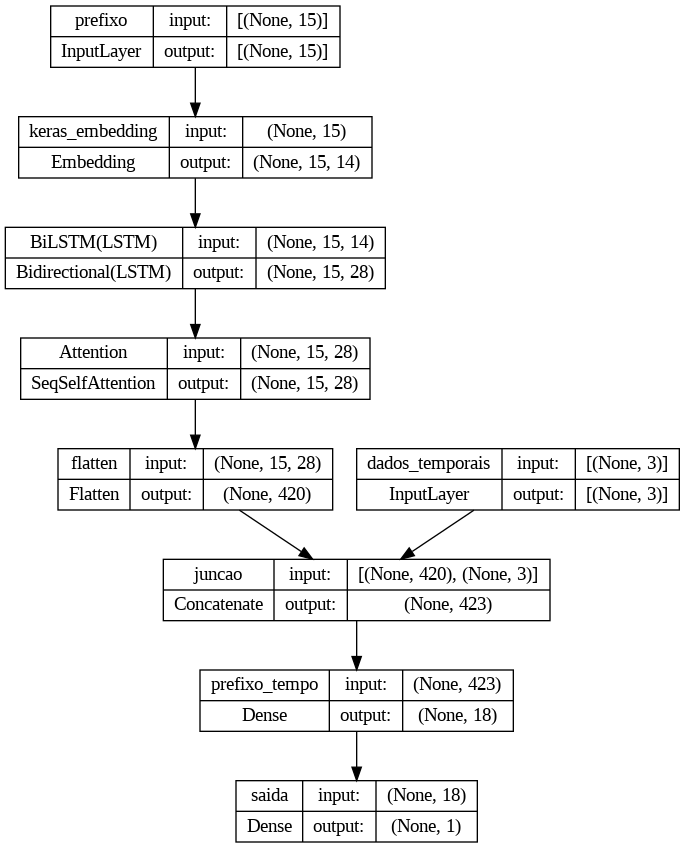

In [ ]:
seq_length = len(ACT_COLS)
seq_length_t = len(TIME_COLS)

input_dim = n_activities + 1

activity_input = Input(shape=(seq_length,), name='prefixo')
time_input = Input(shape=(shape_t,), name='dados_temporais')

embedding_size = n_activities

embedding = Embedding(output_dim=embedding_size,
                      input_dim=input_dim,
                      input_length=seq_length,
                      name='keras_embedding')(activity_input)

rnn = Bidirectional(LSTM(embedding_size,
                            dropout=0.1, return_sequences=True,
                            recurrent_dropout=0.1,
                            kernel_regularizer=keras.regularizers.l2(0.01), name='LSTM'),
                       name='BiLSTM')(embedding)

att = SeqSelfAttention(
    attention_activation='relu',
    name='Attention')(rnn)

att = Flatten()(att)

x = concatenate([att, time_input], name='juncao')


x = Dense((seq_length + seq_length_t),
          activation='relu',
          name='prefixo_tempo')(x)

x = Dense(1, activation='linear', name='saida')(x)

model = Model(inputs=[activity_input , time_input], outputs=[x])

#model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
nadam = keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.7, beta_2=0.9, epsilon=1e-07, name="Nadam")

adam = keras.optimizers.Nadam(learning_rate=0.01, epsilon=0.01)

model.compile(
    optimizer=nadam,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

es = EarlyStopping(monitor='mean_absolute_error',
                   min_delta=1e-07, #min_delta=1e-04,
                   patience=50, verbose=1)

history = model.fit([dl_x_train, dl_x_t_train], y_train,
                    epochs=2000,
                    batch_size=1200,
                    callbacks=[TqdmCallback(verbose=0), es],
                    validation_data=[[dl_x_val, dl_x_t_val], y_val],
                    verbose=0)

0epoch [00:00, ?epoch/s]

Epoch 850: early stopping


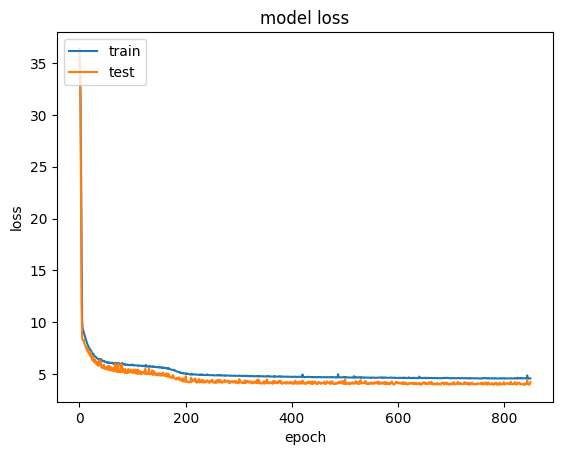

In [ ]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_predicton = model.predict([dl_x_test,dl_x_t_test])

104/104 [==============================] - 2s 10ms/step


In [ ]:
test_predicton.shape

(3300, 1)

In [ ]:
y_test.shape

(3300,)

In [ ]:
mae_error = mean_absolute_error(y_test, test_predicton)
print(mae_error)

5.893214134534201


In [ ]:
from google.colab import files

df_results = pd.DataFrame(list(zip(y_test, np.squeeze(test_predicton))),columns =['y_test', 'y_pred'])
df_results.to_csv('D) HD17_BiLSTM_SA_CONCAT_PRED_REAL.csv', index=False)

files.download('D) HD17_BiLSTM_SA_CONCAT_PRED_REAL.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
MAX_STEP = df_test['Step'].max()

In [ ]:
MAX_STEP

9

In [ ]:
df_test['Step'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
step = list()
mae = list()

for i in range(1, MAX_STEP+1):
  df_local_test = df_test[df_test['Step'] == i]
  dl_x__local_test = df_local_test[ACT_COLS].values
  dl_x_t_local_test = df_local_test[TIME_COLS].values

  y_local_test = df_local_test[TARGET_COL]
  local_test_predicton = model.predict([dl_x__local_test,dl_x_t_local_test])
  mae_error = mean_absolute_error(y_local_test, local_test_predicton)

  mae.append(mae_error)
  step.append(i)

TypeError: ignored

In [ ]:
for s, m in zip(step,mae):
  print(s,m)

In [ ]:
for s, m in zip(step,mae):
  print(str(round(m, 4)).replace('.',','))

In [ ]:
np.mean(mae)